In [1]:
import pandas as pd
import numpy as np


train_path = './dataset/data_rus_Cyrl_train.tsv'
test_path = './dataset/data_rus_Cyrl_test.tsv'

df_train = pd.read_csv(train_path, sep='\t')
df_test = pd.read_csv(test_path, sep='\t')

categories_train = df_train['category'].value_counts()
categories_test = df_test['category'].value_counts()

categories = pd.concat([categories_train, categories_test], axis=1)
categories.columns = ['train', 'test']

categories.loc['Total'] = categories.sum()

display(categories)

df_train.head()

,train,test
category,,
science/technology,176,51
travel,138,40
politics,102,30
sports,85,25
health,77,22
entertainment,65,19
geography,58,17
Total,701,204


,index_id,category,text
0,431,geography,Турция с трёх сторон окружена морями: на запад...
1,403,science/technology,В начале войны они в основном передвигались по...
2,1592,science/technology,По мере того как знание греческого языка ухудш...
3,993,entertainment,"Впрочем, зимой это другая красота и шарм, с го..."
4,755,entertainment,В этих отелях останавливались богатые и извест...


In [2]:
from collections import Counter

word_freq = Counter()

text_data = df_train['text']

for text in text_data:
    words = text.split()
    word_freq.update(words)


stop_words = []
print("Top 10 most frequent words in the entire dataset:")
for word, freq in word_freq.most_common(10):
    print(f"{word}: {freq}")
    stop_words.append(word)

class_word_freq = {}

for class_name in df_train['category'].unique():
    class_text_data = df_train[df_train['category'] == class_name]['text']
    class_word_freq[class_name] = Counter()
    for text in class_text_data:
        words = text.split()
        class_word_freq[class_name].update(words)

df_class_word_freq = pd.DataFrame(columns=['Class', 'Word', 'Frequency'])

for class_name, freq in class_word_freq.items():
    for word, freq in freq.most_common(10):
        df_class_word_freq = df_class_word_freq._append({'Class': class_name, 'Word': word, 'Frequency': freq}, ignore_index=True)


display(df_class_word_freq)
df_class_word_freq.to_csv('df_class_word_freq.csv', index=False)

Top 10 most frequent words in the entire dataset:
в: 490
и: 396
на: 224
что: 144
с: 134
не: 101
по: 100
как: 95
или: 86
из: 84


,Class,Word,Frequency
0,geography,в,33
1,geography,и,32
2,geography,на,23
3,geography,из,16
4,geography,—,15
...,...,...,...
65,sports,не,14
66,sports,для,12
67,sports,что,10
68,sports,это,9


## BOW without anything ##

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train, y_train = df_train['text'], df_train['category']
X_test, y_test = df_test['text'], df_test['category']

vectorizer = CountVectorizer()

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_bow)
X_test_scaled = scaler.transform(X_test_bow)

model = LogisticRegression(n_jobs=-1)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="macro")

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

print(f"Accuracy: {acc:.2f}, F1: {f1:.2f}")
print("Top words for categories: ")

for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(coefs[i])[-10:]  
    print(f"\t{class_label}: {', '.join(feature_names[top10])}\n")

with open("vocabulary_lemmatized_p.txt", "w") as f:
    for word in feature_names:
        f.write(word + "\n")

Accuracy: 0.66, F1: 0.61
Top words for categories: 
	entertainment: пирамиды, расслабиться, развлечься, повседневной, группа, сцены, публике, телевизоров, угодить, шоу

	geography: величине, метеоритов, амазонка, архипелаг, раскинувшийся, кв, японию, океане, плато, км

	health: больницу, заболевания, случаев, самоизолируется, стабильное, первых, сообщено, аварии, заят, пострадал

	politics: слухи, глупостью, германия, индией, атака, баллотироваться, политической, выборов, президенты, 2016

	science/technology: используете, клавиатурой, гадать, элементы, солнца, чего, фотоны, дало, атомы, состоят

	sports: спорта, вернутся, маршрут, пешеходный, представьте, 2009, лыжный, забил, гольф, олимпийских

	travel: неприятные, ивасаки, попадал, туристы, путешественник, путешествия, посетить, места, провести, посетителям



/tmp/ipykernel_56664/270633423.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


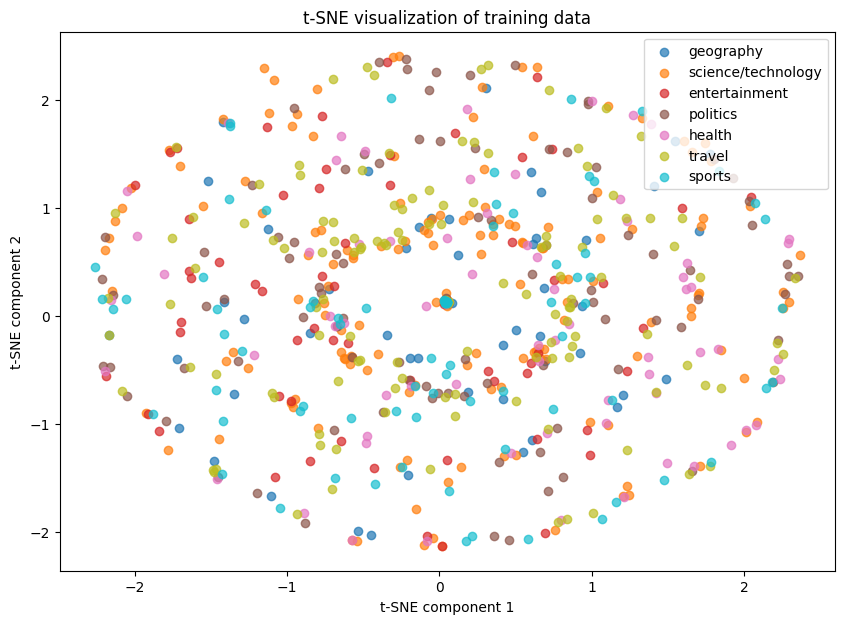

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_train_scaled = X_train_scaled.toarray()

tsne = TSNE(n_components=2, random_state=20)
X_train_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 7))

unique_labels = y_train.unique()

colors = plt.cm.get_cmap("tab10", len(unique_labels))

for i, label in enumerate(unique_labels):
    indices = (y_train == label)
    plt.scatter(X_train_tsne[indices, 0], X_train_tsne[indices, 1], 
                label=label, c=[colors(i)], alpha=0.7)

plt.title('t-SNE visualization of training data')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(loc='best')
plt.show()


## BOW with adding stop words ##

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train, y_train = df_train['text'], df_train['category']
X_test, y_test = df_test['text'], df_test['category']

vectorizer = CountVectorizer(stop_words=stop_words)

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_bow)
X_test_scaled = scaler.transform(X_test_bow)

model = LogisticRegression(n_jobs=-1)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="macro")

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

print(f"Accuracy: {acc:.2f}, F1: {f1:.2f}")
print("Top words for categories: ")

for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(coefs[i])[-10:]  
    print(f"\t{class_label}: {', '.join(feature_names[top10])}\n")

with open("vocabulary_lemmatized_p.txt", "w") as f:
    for word in feature_names:
        f.write(word + "\n")

Accuracy: 0.65, F1: 0.61
Top words for categories: 
	entertainment: пирамидах, расслабиться, повседневной, развлечься, группа, сцены, угодить, публике, телевизоров, шоу

	geography: островов, амазонка, метеоритов, архипелаг, раскинувшийся, кв, японию, океане, плато, км

	health: больницу, заболевания, случаев, стабильное, самоизолируется, первых, сообщено, аварии, заят, пострадал

	politics: болтовнёй, глупостью, германия, атака, индией, баллотироваться, политической, выборов, 2016, президенты

	science/technology: даже, клавиатурой, гадать, элементы, солнца, чего, фотоны, дало, атомы, состоят

	sports: матчи, пешеходный, маршрут, представьте, вернутся, 2009, лыжный, забил, гольф, олимпийских

	travel: ивасаки, неприятные, попадал, туристы, путешественник, путешествия, места, посетить, провести, посетителям



## BOW with spacy ##

In [20]:
import spacy
from sklearn.preprocessing import StandardScaler

nlp = spacy.load("ru_core_news_sm")

def tokenize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_punct])


df_train_spacy, df_test_spacy = df_train.copy(), df_test.copy()

df_train_spacy['text'] = df_train_spacy['text'].apply(tokenize)
df_test_spacy['text'] = df_test_spacy['text'].apply(tokenize)

X_train, y_train = df_train_spacy['text'], df_train_spacy['category']
X_test, y_test = df_test_spacy['text'], df_test_spacy['category']

vectorizer = CountVectorizer()

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_bow)
X_train_scaled = X_train_bow
X_test_scaled = scaler.transform(X_test_bow)

model = LogisticRegression(n_jobs=-1)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="macro")

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

print(f"Accuracy: {acc:.2f}, F1: {f1:.2f}")
print("Top words for categories: ")

for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(coefs[i])[-10:]  
    print(f"\t{class_label}: {', '.join(feature_names[top10])}\n")

with open("vocabulary_lemmatized_p.txt", "w") as f:
    for word in feature_names:
        f.write(word + "\n")


Accuracy: 0.71, F1: 0.69
Top words for categories: 
	entertainment: сайт, исполнить, японский, хороший, фестиваль, группа, певец, сцена, событие, шоу

	geography: гора, из, являться, миля, плато, км, океан, активность, земля, остров

	health: вирус, мозг, боль, проблема, от, болезнь, медицинский, случай, пострадать, заболевание

	politics: отношение, президент, министр, год, война, свой, германия, выбор, протест, правительство

	science/technology: телескоп, создание, помощь, элемент, солнце, использоваться, атом, технология, учёный, интернет

	sports: лыжа, лыжный, сезон, спорт, после, команда, игрок, олимпийский, матч, игра

	travel: до, вы, автобус, пассажир, поездка, пункт, турист, путешествие, место, путешественник



## BOW with pymorphi ##

In [7]:
import pymorphy2
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np

morph = pymorphy2.MorphAnalyzer()

def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalpha()]
    return " ".join(lemmatized_tokens)

df_train_pymorphi = df_train.copy()
df_test_pymorphi = df_test.copy()

df_train_pymorphi['text'] = df_train_pymorphi['text'].apply(tokenize)
df_test_pymorphi['text'] = df_test_pymorphi['text'].apply(tokenize)

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(df_train_pymorphi['text'])
X_test = vectorizer.transform(df_test_pymorphi['text'])

y_train = df_train_pymorphi['category']
y_test = df_test_pymorphi['category']

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(n_jobs=-1)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="macro")

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

print(f"Accuracy: {acc:.2f}, F1: {f1:.2f}")
print("Top words for categories: ")

for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(coefs[i])[-10:]  
    print(f"\t{class_label}: {', '.join(feature_names[top10])}\n")

with open("vocabulary_lemmatized_p.txt", "w") as f:
    for word in feature_names:
        f.write(word + "\n")


Accuracy: 0.70, F1: 0.68
Top words for categories: 
	entertainment: qvc, освещаться, фестиваль, изысканный, шоу, пирамида, рок, гастролировать, сцена, угодить

	geography: река, плато, миля, восточный, км, мадагаскар, тёплый, амазонка, остров, океан

	health: глаз, болезнь, авария, проблема, заят, сообщить, самоизолироваться, пострадать, случай, заболевание

	politics: президент, одобрить, атака, палата, протест, правительство, выборы, предполагаться, люксембург, баллотироваться

	science/technology: xvi, солнце, учёный, телескоп, оно, элемент, звонить, состоять, фотон, атом

	sports: гольф, гол, игрок, турнир, команда, олимпийский, забить, игра, матч, лыжный

	travel: требование, посетить, посещение, авиалиния, путешествие, велосипедный, независимо, турист, путешественник, посетитель



## TFIDF without anything ##

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

X_train, y_train = df_train['text'], df_train['category']
X_test, y_test = df_test['text'], df_test['category']

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = LogisticRegression(n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="macro")

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

print(f"Accuracy: {acc:.2f}, F1: {f1:.2f}")
print("Top words for categories: ")
for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(coefs[i])[-10:]
    print(f"\t{class_label}: {', '.join(feature_names[top10])}\n")

Accuracy: 0.65, F1: 0.59
Top words for categories: 
	entertainment: показывают, развлечься, повседневной, расслабиться, группа, телевизоров, публике, угодить, сцены, шоу

	geography: метеоритов, островов, амазонка, рекой, японию, океане, земле, величине, плато, км

	health: глаз, скончался, сообщено, первых, больницу, случаев, заболевания, аварии, заят, пострадал

	politics: болтовнёй, пакистаном, году, протесты, президенты, 2016, баллотироваться, политической, германия, выборов

	science/technology: даже, используете, фотоны, учёные, дало, что, элементы, солнца, состоят, атомы

	sports: игрок, победу, 2009, пешеходный, маршрут, представьте, забил, спорта, олимпийских, лыжный

	travel: авиакомпании, независимо, туристы, путешественник, туристов, путешествия, посетителям, посетить, места, провести



## TFIDF with Spacy ##

In [9]:
from sklearn.preprocessing import StandardScaler

nlp = spacy.load("ru_core_news_sm")

def tokenize(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha]
    return " ".join(lemmatized_tokens)

df_train_spacy, df_test_spacy = df_train.copy(), df_test.copy()

df_train_spacy['text'] = df_train_spacy['text'].apply(tokenize)
df_test_spacy['text'] = df_test_spacy['text'].apply(tokenize)

X_train, y_train = df_train_spacy['text'], df_train_spacy['category']
X_test, y_test = df_test_spacy['text'], df_test_spacy['category']

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="macro")

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

print(f"Accuracy: {acc:.2f}, F1: {f1:.2f}")
print("Top words for categories: ")
for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(coefs[i])[-10:]
    print(f"\t{class_label}: {', '.join(feature_names[top10])}\n")


Accuracy: 0.69, F1: 0.67
Top words for categories: 
	entertainment: qvc, искусство, концерт, публика, фестиваль, рок, гастролировать, угодить, сцена, шоу

	geography: активность, плато, река, миля, тёплый, земля, амазонка, км, океан, остров

	health: глаз, самоизолируется, заят, болезнь, медицинский, авария, проблема, случай, пострадать, заболевание

	politics: год, предполагаться, пакистан, президент, баллотироваться, германия, протест, люксембург, выбор, правительство

	science/technology: использоваться, звонить, фотон, телескоп, интернет, элемент, состоять, солнце, атом, учёный

	sports: спорт, паралимпийский, турнир, забить, команда, игрок, олимпийский, матч, игра, лыжный

	travel: пункт, билет, место, поездка, посещение, посетитель, независимо, путешествие, путешественник, турист



In [10]:
import pymorphy2
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import re

morph = pymorphy2.MorphAnalyzer()

def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalpha()]
    return " ".join(lemmatized_tokens)

df_train_pymorphi, df_test_pymorphi = df_train.copy(), df_test.copy()

df_train_pymorphi['text'] = df_train_pymorphi['text'].apply(tokenize)
df_test_pymorphi['text'] = df_test_pymorphi['text'].apply(tokenize)

X_train, y_train = df_train_pymorphi['text'], df_train_pymorphi['category']
X_test, y_test = df_test_pymorphi['text'], df_test_pymorphi['category']

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="macro")

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

print(f"Accuracy: {acc:.2f}, F1: {f1:.2f}")
print("Top words for categories: ")
for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(coefs[i])[-10:]
    print(f"\t{class_label}: {', '.join(feature_names[top10])}\n")


Accuracy: 0.71, F1: 0.69
Top words for categories: 
	entertainment: изысканный, пирамида, cowparade, июнь, фестиваль, угодить, гастролировать, рок, шоу, сцена

	geography: плато, восточный, тёплый, миля, величина, км, река, амазонка, океан, остров

	health: глаз, заят, авария, медицинский, болезнь, проблема, самоизолироваться, случай, пострадать, заболевание

	politics: предполагаться, военный, год, президент, германия, протест, баллотироваться, люксембург, правительство, выборы

	science/technology: фотон, звонить, телескоп, материя, элемент, солнце, интернет, состоять, учёный, атом

	sports: спорт, забить, турнир, гол, команда, игрок, олимпийский, игра, лыжный, матч

	travel: пункт, поездка, место, туризм, посещение, посетитель, независимо, путешествие, путешественник, турист



In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import pymorphy2
import re

morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    words = re.findall(r'\b\w+\b', text.lower())
    lemmas = [morph.parse(word)[0].normal_form for word in words if word.isalpha()]
    return ' '.join(lemmas)

X_train, y_train = df_train['text'], df_train['category']
X_test, y_test = df_test['text'], df_test['category']

categories = df_train['category'].unique()
text = []

for category in categories:
    text_class = df_train[df_train['category'] == category]
    combined_text = ' '.join(text_class['text'].apply(preprocess_text).to_list())
    text.append(combined_text)

vectorizer = TfidfVectorizer()
vectorizer.fit(text)
X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)
X_train_tfidf = vectorizer.transform(X_train_processed)
X_test_tfidf = vectorizer.transform(X_test_processed)

scaler = StandardScaler(with_mean=False)
X_train123 = scaler.fit_transform(X_train_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)

print(X_test_tfidf.shape)

model = LogisticRegression(n_jobs=-1)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

print(f"Accuracy: {acc:.2f}, F1: {f1:.2f}")
print("Top words for categories: ")
for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(coefs[i])[-10:]
    print(f"\t{class_label}: {', '.join(feature_names[top10])}\n")


(204, 4192)
Accuracy: 0.75, F1: 0.74
Top words for categories: 
	entertainment: the, сцена, выставка, исполнить, хороший, бхаджан, событие, фестиваль, певец, шоу

	geography: плато, поверхность, активность, река, из, км, океан, земля, миля, остров

	health: вирус, сон, проблема, медицинский, боль, от, случай, болезнь, пострадать, заболевание

	politics: военный, пакистан, министр, германия, свой, протест, война, год, выборы, правительство

	science/technology: материя, телескоп, что, объектив, использоваться, учёный, технология, солнце, интернет, атом

	sports: клуб, лыжный, сезон, команда, гол, игрок, спорт, игра, матч, олимпийский

	travel: билет, для, авиакомпания, мочь, место, турист, поездка, путешествие, путешественник, вы



In [36]:
import pandas as pd
from nlpaug.augmenter.word import ContextualWordEmbsAug
from tqdm import tqdm  # Для прогресс-бара

augmenter = ContextualWordEmbsAug(model_path='cointegrated/rubert-tiny', action="substitute")

augmented_data = []

for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
    text = row['text']
    category = row['category']
    
    augmented_text = augmenter.augment(text)
    
    augmented_data.append({'text': augmented_text, 'category': category})

df_out = pd.DataFrame(augmented_data)

df_out.to_csv('train_aug.csv', index=False)


/home/kirill/NLP/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 701/701 [04:00<00:00,  2.92it/s]


In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pymorphy2
import re

morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    words = re.findall(r'\b\w+\b', text.lower())
    lemmas = [morph.parse(word)[0].normal_form for word in words if word.isalpha()]
    return ' '.join(lemmas)

X_train, y_train = df_train['text'], df_train['category']
X_test, y_test = df_test['text'], df_test['category']

df_aug = pd.read_csv('train_aug.csv')

df_combined = pd.concat([df_train, df_aug])

df_combined['text'] = df_combined['text'].apply(preprocess_text)

label_encoder = LabelEncoder()
y_train_combined = label_encoder.fit_transform(df_combined['category'])
y_test_encoded = label_encoder.transform(y_test)

vectorizer = TfidfVectorizer()
vectorizer.fit(df_combined['text'])

X_train_processed = df_combined['text'].apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)
X_train_tfidf = vectorizer.transform(X_train_processed)
X_test_tfidf = vectorizer.transform(X_test_processed)

scaler = StandardScaler(with_mean=False)
scaler.fit_transform(X_train_tfidf)
X_train_scaled = X_train_tfidf
X_test_scaled = scaler.transform(X_test_tfidf)

model = LogisticRegression(n_jobs=-1)
model.fit(X_train_scaled, y_train_combined)

y_pred = model.predict(X_test_scaled)

y_pred_labels = label_encoder.inverse_transform(y_pred)

acc = accuracy_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels, average="macro")

feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

print(f"Accuracy: {acc:.2f}, F1: {f1:.2f}")
print("Top words for categories: ")
for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(coefs[i])[-10:]
    print(f"\t{label_encoder.inverse_transform([class_label])[0]}: {', '.join(feature_names[top10])}\n")


Accuracy: 0.71, F1: 0.70
Top words for categories: 
	entertainment: большинство, концерт, вместе, японский, певец, расположить, музыка, искусство, фестиваль, шоу

	geography: являться, км, из, плато, поверхность, миля, море, океан, остров, земля

	health: не, вирус, сон, боль, медицинский, проблема, болезнь, пострадать, случай, заболевание

	politics: выборы, германия, протест, штат, президент, министр, свой, год, правительство, война

	science/technology: газ, создание, животное, интернет, использование, учёный, элемент, атом, солнце, технология

	sports: выиграть, спортсмен, клуб, соревнование, игрок, матч, гол, игра, спорт, олимпийский

	travel: пункт, или, для, путешественник, мочь, турист, путешествие, поездка, место, вы

